# Chapter 13 – Loading and Preprocessing Data with TensorFlow

This notebook contains all the sample code and solutions to the exercises in chapter 13.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

## The tf.data API

In [4]:
import tensorflow as tf

X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [6]:

X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## Chaining Transformations

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [8]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [9]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [10]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## Shuffling the Data

In [11]:

dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### Interleaving lines from multiple files
Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set:

In [12]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [13]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [14]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [15]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

### Building an Input Pipeline

In [16]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [17]:
# extra code – shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [18]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [19]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


## Preprocessing the Data

In [20]:

# extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [21]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [22]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together + Prefetching

In [23]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [24]:
# extra code – show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



In [25]:
# extra code – list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()        

## Using the Dataset with Keras

In [26]:

train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [27]:

# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)


Epoch 1/5

363/363 [==============================] - 1s 1ms/step - loss: 2.3139 - val_loss: 0.4915
Epoch 2/5
363/363 [==============================] - 0s 991us/step - loss: 0.7088 - val_loss: 341.3863
Epoch 3/5
363/363 [==============================] - 0s 694us/step - loss: 0.8837 - val_loss: 2.0681
Epoch 4/5
363/363 [==============================] - 0s 697us/step - loss: 0.4329 - val_loss: 0.3815
Epoch 5/5
363/363 [==============================] - 0s 701us/step - loss: 0.3931 - val_loss: 0.5081


In [29]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

3/3 [==============================] - 0s 2ms/step



**Warning**: the ```mean_squared_error()``` function no longer exists. You must now use an instance of the MeanSquaredError class instead.

In [30]:
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [31]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

### The TFRecord Format

A TFRecord file is just a list of binary records. You can create one using a ```tf.io.TFRecordWriter```:

In [32]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a ```tf.data.TFRecordDataset```:

In [33]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one ```TFRecordDataset```. By default it will read them one at a time, but if you set ```num_parallel_reads=3```, it will read 3 at a time in parallel and interleave their records:

In [34]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### Compressed TFRecord Files

In [35]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [36]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [37]:
# extra code – shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


### A Brief Introduction to Protocol Buffers

For this section you need to install protobuf. In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type tf.train.Example, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (protoc): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [38]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


And let's compile it (the ```--descriptor_set_out``` and ```--include_imports``` options are only required for the ```tf.io.decode_proto()``` example below):

In [39]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [40]:
%ls person*

 Volume in drive C has no label.
 Volume Serial Number is EAF7-B3FB

 Directory of c:\Users\schre\OneDrive\Documents\GitHub\HOML3e

12/02/2024  12:14 PM                92 person.desc
12/02/2024  12:14 PM               114 person.proto
12/02/2024  12:14 PM               986 person_pb2.py
               3 File(s)          1,192 bytes
               0 Dir(s)  1,700,106,084,352 bytes free


In [41]:
from person_pb2 import Person  # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [42]:

person.name  # read a field

'Al'

In [43]:

person.name = "Alice"  # modify a field

In [44]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [45]:
person.email.append("c@d.com")  # add an email address

In [46]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [47]:
person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (27 bytes long)

27

In [48]:

person == person2  # now they are equal

True

### Custom protobuf
In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the ```tf.io.decode_proto() ```function:

In [49]:

# extra code – shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the ```tf.io.decode_proto()``` documentation.

## TensorFlow Protobufs
Here is the definition of the tf.train.Example protobuf:

```syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [50]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

In [51]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

### Loading and Parsing Examples

In [52]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

#Print out data in my_contacts example file
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

In [53]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [54]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [55]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # parse example file two at a time (number of batches)

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=s

In [56]:
parsed_examples

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

### Extra Material – Storing Images and Tensors in TFRecords

Let's load and display an example image:

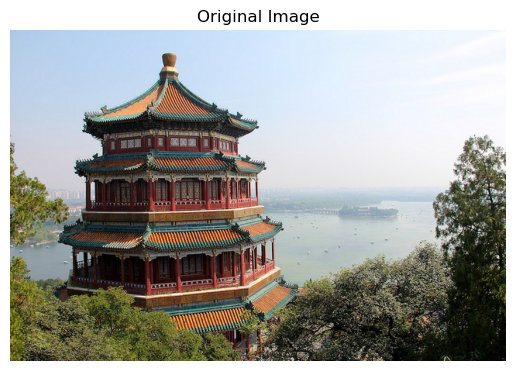

In [57]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()